## 1️⃣ Analyse des données

### Tâches
1. Examiner la structure du dataset.
2. Détecter et traiter les valeurs manquantes et doublons.
3. Analyser la distribution de la variable cible.
4. Générer des WordClouds.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ramas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 1. Chargement et Inspection des données

In [2]:
df = pd.read_csv('../data/raw/DataSet_Emails.csv')

df.shape

(31716, 8)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31716 entries, 0 to 31715
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31716 non-null  int64 
 1   message_id  31716 non-null  int64 
 2   text        31665 non-null  object
 3   label       31716 non-null  int64 
 4   label_text  31716 non-null  object
 5   subject     31442 non-null  object
 6   message     31371 non-null  object
 7   date        31716 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.9+ MB


In [4]:
print(f"Dimensions du dataset : {df.shape}")

Dimensions du dataset : (31716, 8)


### 2. Nettoyage des données (Valeurs manquantes et Doublons)

In [5]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
Unnamed: 0      0
message_id      0
text           51
label           0
label_text      0
subject       274
message       345
date            0
dtype: int64


In [6]:
df = df.drop(columns=['Unnamed: 0', 'message_id', 'subject', 'message', 'date'])

df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]


In [7]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
text          0
label         0
label_text    0
dtype: int64


In [8]:
# Vérification des doublons
doublons = df.duplicated().sum()
print(f"Nombre de doublons : {doublons}")

Nombre de doublons : 2854


In [9]:
# Suppression des doublons
print(f"Dimensions avant suppression des doublons : {df.shape}")
df = df.drop_duplicates()
print(f"Dimensions après suppression des doublons : {df.shape}")

Dimensions avant suppression des doublons : (31665, 3)
Dimensions après suppression des doublons : (28811, 3)


### 3. Analyse de la distribution (Spam vs Ham)

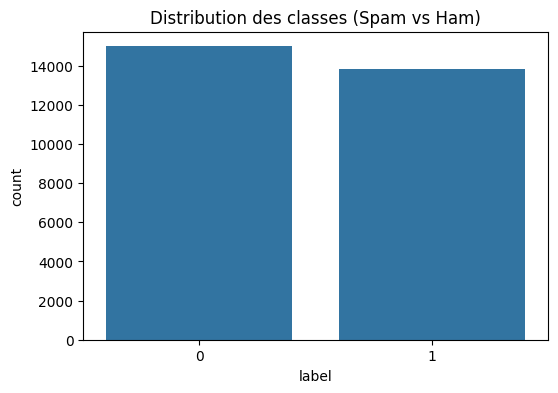

label
0    0.52001
1    0.47999
Name: proportion, dtype: float64


In [10]:
# Visualisation de la distribution
target_col = 'label'

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title('Distribution des classes (Spam vs Ham)')
plt.show()

print(df[target_col].value_counts(normalize=True))

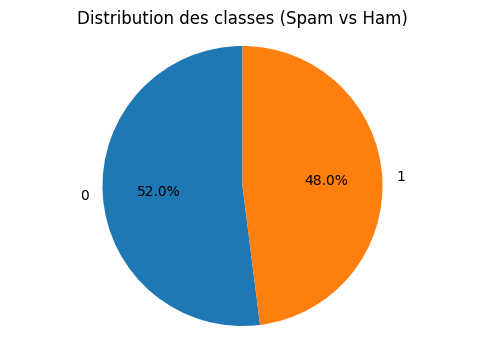

label
0    0.52001
1    0.47999
Name: proportion, dtype: float64


In [11]:

counts = df[target_col].value_counts()
labels = counts.index
sizes = counts.values

plt.figure(figsize=(6, 4))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution des classes (Spam vs Ham)')
plt.axis('equal')
plt.show()

print(df[target_col].value_counts(normalize=True))

In [12]:
# les colonnes : 
print(df.columns)
df.head(5)

Index(['text', 'label', 'label_text'], dtype='object')


,text,label,label_text
0,any software just for 15 $ - 99 $ understandin...,1,spam
1,perspective on ferc regulatory action client c...,0,ham
2,wanted to try ci 4 lis but thought it was way ...,1,spam
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham
4,looking for cheap high - quality software ? ro...,1,spam


### 4. WordClouds

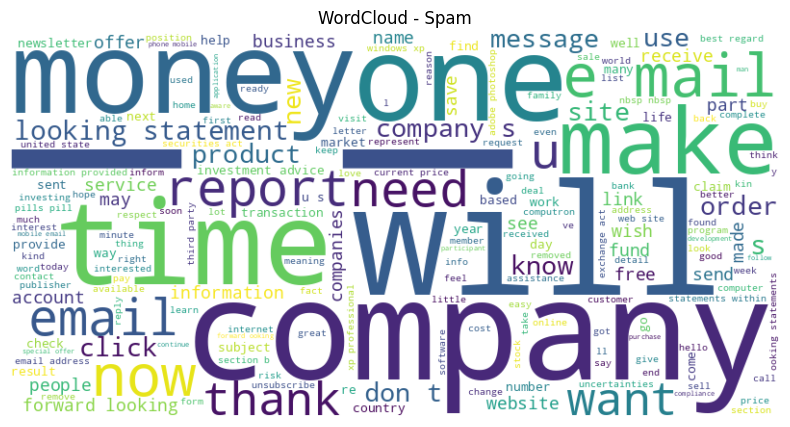

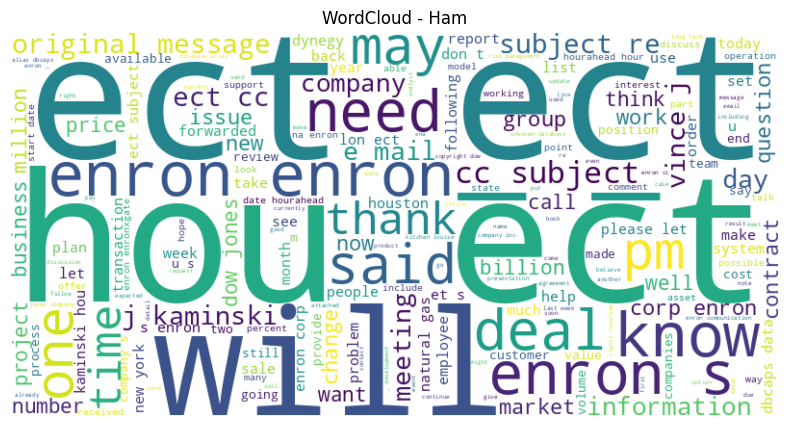

In [13]:
# Fonction pour générer un WordCloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


spam_text = " ".join(df[df['label_text'] == 'spam']['text'].astype(str).tolist())
ham_text = " ".join(df[df['label_text'] == 'ham']['text'].astype(str).tolist())

# WordCloud Spam
plot_wordcloud(spam_text, "WordCloud - Spam")

# WordCloud Ham
plot_wordcloud(ham_text, "WordCloud - Ham")

## 2️⃣ Prétraitement du texte

### Tâches
1. Nettoyage et normalisation du texte
2. Tokenisation et filtrage des mots
3. Vectorisation du texte


### 1. Nettoyage et normalisation du texte

#### ➕ Convertir tout le texte en minuscules

In [14]:
#
df['text'] = df['text'].str.lower().str.strip()
# df['subject'] = df['subject'].str.lower().str.strip()

#### ➕ Supprimer les lignes vides ou incomplètes

In [15]:
df.isnull().sum()

text          0
label         0
label_text    0
dtype: int64

In [16]:
df = df.dropna(subset=["text"])

df["text"] = df["text"].str.strip()

df = df[df["text"] != ""]

df.shape

(28811, 3)

#### ➕ Supprimer la ponctuation et les caractères spéciaux

In [17]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    text = re.sub(r'\S+@\S+', '', text)  # emails
    text = re.sub(r'\d+', '', text)  # chiffres
    text = text.translate(str.maketrans('', '', string.punctuation))  # ponctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['text'] = df['text'].apply(clean_text)

df.head(5)


,text,label,label_text
0,any software just for understanding oem softwa...,1,spam
1,perspective on ferc regulatory action client c...,0,ham
2,wanted to try ci lis but thought it was way to...,1,spam
3,enron hpl actuals for december teco tap enron ...,0,ham
4,looking for cheap high quality software rotate...,1,spam


In [18]:
df['text'].isna().sum()

np.int64(0)

In [19]:
df_null = df[(df['text'] == "")]
df = df[df['text'] != ""]
df.shape

(28808, 3)

In [20]:
df_null.head()

,text,label,label_text
9648,,1,spam
10562,,1,spam
24407,,1,spam


In [21]:
df.shape


(28808, 3)

### 2. Tokenisation et filtrage des mots

#### ➕ Tokeniser le texte

In [22]:

def tokenize_text(text):
    return word_tokenize(text)

df['text_tokenized'] = df['text'].apply(tokenize_text)
df.head()


,text,label,label_text,text_tokenized
0,any software just for understanding oem softwa...,1,spam,"[any, software, just, for, understanding, oem,..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, on, ferc, regulatory, action, cl..."
2,wanted to try ci lis but thought it was way to...,1,spam,"[wanted, to, try, ci, lis, but, thought, it, w..."
3,enron hpl actuals for december teco tap enron ...,0,ham,"[enron, hpl, actuals, for, december, teco, tap..."
4,looking for cheap high quality software rotate...,1,spam,"[looking, for, cheap, high, quality, software,..."


#### ➕ Supprimer les stopwords

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['text_no_stopwords'] = df['text_tokenized'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,label_text,text_tokenized,text_no_stopwords
0,any software just for understanding oem softwa...,1,spam,"[any, software, just, for, understanding, oem,...","[software, understanding, oem, software, lead,..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, on, ferc, regulatory, action, cl...","[perspective, ferc, regulatory, action, client..."
2,wanted to try ci lis but thought it was way to...,1,spam,"[wanted, to, try, ci, lis, but, thought, it, w...","[wanted, try, ci, lis, thought, way, expensive..."
3,enron hpl actuals for december teco tap enron ...,0,ham,"[enron, hpl, actuals, for, december, teco, tap...","[enron, hpl, actuals, december, teco, tap, enr..."
4,looking for cheap high quality software rotate...,1,spam,"[looking, for, cheap, high, quality, software,...","[looking, cheap, high, quality, software, rota..."


#### ➕ Appliquer le stemming (PorterStemmer)

In [24]:
stemmer = PorterStemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]

df['text_stemmed'] = df['text_no_stopwords'].apply(stem_text)
df.head()

,text,label,label_text,text_tokenized,text_no_stopwords,text_stemmed
0,any software just for understanding oem softwa...,1,spam,"[any, software, just, for, understanding, oem,...","[software, understanding, oem, software, lead,...","[softwar, understand, oem, softwar, lead, temp..."
1,perspective on ferc regulatory action client c...,0,ham,"[perspective, on, ferc, regulatory, action, cl...","[perspective, ferc, regulatory, action, client...","[perspect, ferc, regulatori, action, client, c..."
2,wanted to try ci lis but thought it was way to...,1,spam,"[wanted, to, try, ci, lis, but, thought, it, w...","[wanted, try, ci, lis, thought, way, expensive...","[want, tri, ci, li, thought, way, expens, viag..."
3,enron hpl actuals for december teco tap enron ...,0,ham,"[enron, hpl, actuals, for, december, teco, tap...","[enron, hpl, actuals, december, teco, tap, enr...","[enron, hpl, actual, decemb, teco, tap, enron,..."
4,looking for cheap high quality software rotate...,1,spam,"[looking, for, cheap, high, quality, software,...","[looking, cheap, high, quality, software, rota...","[look, cheap, high, qualiti, softwar, rotat, n..."


In [25]:
df['text_stemmed'][0]

['softwar',
 'understand',
 'oem',
 'softwar',
 'lead',
 'temptat',
 'find',
 'way',
 'law',
 'disregard',
 'trifl']

### 3. Vectorisation du texte

### ➕ split data : 

In [26]:
X = df['text_stemmed']
y = df['label'].map({'ham':0, 'spam':1}) if df['label'].dtype == object else df['label']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### ➕ Appliquer TF-IDF ou CountVectorizer

In [ ]:


X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

print(X_train.head())
print(X_test.head())

14367    chemist provid custom wide select qualiti medi...
25946    power propos houston visit ehud thank fro mess...
28056    worldpow mark agre seem market penetr need ben...
21030    lng may decis john ye addit info transact vinc...
5108     resum marshal shall call wednesday vinc marsha...
Name: text_stemmed, dtype: object
25761    tadalafil soft tab great result hi new product...
20867    wow never onlin anyor dear rait bruce guenter ...
25254    bpa feb loss bill pleas advis bill bpa tranni ...
12443    astound mortgag simplifi homeown pre approv ho...
17791    special asset statu attach june narr report un...
Name: text_stemmed, dtype: object


In [28]:
train_df = pd.DataFrame({'text_final': X_train, 'label': y_train})
test_df = pd.DataFrame({'text_final': X_test, 'label': y_test})

In [29]:

# Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Fit and Transform
tfidf_train = vectorizer.fit_transform(train_df['text_final'])
tfidf_test = vectorizer.transform(test_df['text_final'])


In [30]:
print(f"===> tfidf_train.shape : {tfidf_train.shape}  pourcentage :  {((tfidf_train.shape[0]/df.shape[0])*100):.2f}")
print(f"===> tfidf_test.shape : { tfidf_test.shape}  pourcentage :  {((tfidf_test.shape[0]/df.shape[0])*100):.2f}")

row0 = tfidf_train[:10].toarray()
pd.DataFrame(row0, columns=vectorizer.get_feature_names_out())



===> tfidf_train.shape : (23046, 102224)  pourcentage :  80.00
===> tfidf_test.shape : (5762, 102224)  pourcentage :  20.00


,aa,aaa,aaaa,aaaaci,aaadrizzl,aaaenerfax,aaal,aaaplusdirect,aaasash,aab,...,þtý,þu,þya,þá,þãõ,þí,þîñõþàà,þô,þöyledir,þù
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'þô', 'þöyledir', 'þù'],
      shape=(102224,), dtype=object)